In [1]:
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

import os.path as op
import sys
sys.path.append("../")

from src import regmod
from src import utils
from src import solver

## Synthetic Example

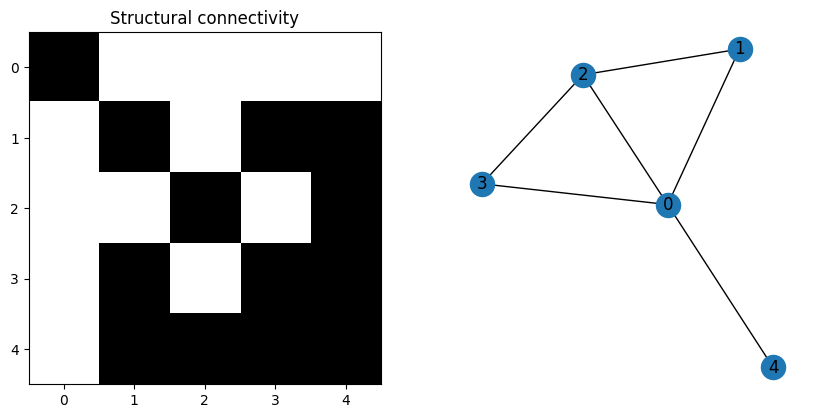

In [2]:
path_to_data = "../resources"

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

filename = "adjacency_synthetic.pkl"

adj = utils.load(op.join(path_to_data, filename))
adj -= np.diag(np.diag(adj))

axes[0].imshow(adj, cmap='gray')
axes[0].set_title('Structural connectivity')
toy_graph = nx.Graph(adj)
nx.draw(toy_graph, ax=axes[1], with_labels=True)

### Example of a forward pass

  0%|          | 0/20 [00:00<?, ?it/s]

Early stopping !


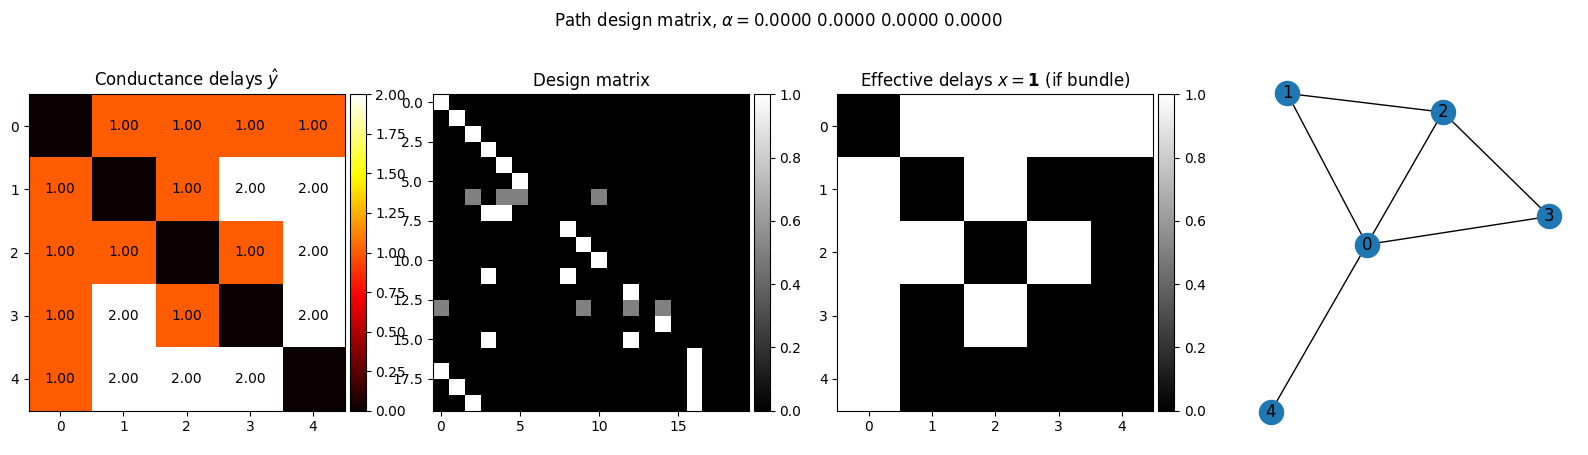

In [3]:
max_path_depth = 4

multi_hops_design = regmod.get_path_matrices(adj, max_path_depth)

a = 0
# Computes the alpha vector as alpha_n = a^n
alpha = [a**(i+1) for i in range(max_path_depth)]
#alpha = a

design_shortest = regmod.combine_paths_matrices(multi_hops_design, alpha=alpha)
design_model = design_shortest

y_pred_mat = regmod.predict_conduction_delays(design_model, adj, invert_weights=False)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(rf"Path design matrix, $\alpha=$"+" ".join([f"{a:1.4f}" for a in list(alpha)]))
axes[0].imshow(y_pred_mat, cmap='hot')
axes[0].set_title("Conductance delays $\hat{y}$")
utils.add_cbar(fig, axes[0])
utils.annotate_heatmap(fig, axes[0], y_pred_mat, adapt_color=0.6)

axes[1].imshow(design_model, cmap='gray')#, vmax=y_pred_mat.max())
axes[1].set_title("Design matrix")
utils.add_cbar(fig, axes[1])

axes[2].imshow(adj, cmap='gray')#, vmax=y_pred_mat.max())
axes[2].set_title("Effective delays $x=\mathbf{1}$ (if bundle)")
utils.add_cbar(fig, axes[2])

nx.draw(toy_graph, ax=axes[3], with_labels=True)

### Backward pass: Jointly optimizing effective delays and alphas

In [4]:
max_path_depth = 4
multi_hops_design = regmod.get_path_matrices(adj, max_path_depth)

  0%|          | 0/20 [00:00<?, ?it/s]

In [5]:
x_ground = utils.remove_diagonal_entries(adj).flatten()

a = 0
# Computes the alpha vector as alpha_n = a^n
alpha = solver.torch.tensor([a**(i+1) for i in range(max_path_depth)])

design_model = solver.combine_paths_matrices_torch(solver.torch.tensor(multi_hops_design), alpha=alpha)
y_pred = solver.forward(design_model, solver.torch.tensor(x_ground))

In [6]:
from copy import deepcopy
np.random.seed(99)
y_ground = solver.torch.tensor(deepcopy(y_pred))
x_init = solver.torch.tensor(np.random.rand(len(x_ground))).requires_grad_(True)
# alphas_init = solver.torch.tensor(np.random.rand(len(alpha))).requires_grad_(True)

/var/folders/9t/60tqjhtx2h55525lstv8nsc40000gn/T/ipykernel_28642/4112780630.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ground = solver.torch.tensor(deepcopy(y_pred))


In [7]:
x = deepcopy(x_init)
x_opt, loss = solver.naive_gradient_descent(x, y_ground, 0, solver.torch.tensor(multi_hops_design),
                                       n_iter=3000, verbose=False)

(<Figure size 1000x500 with 4 Axes>,
 <Axes: title={'center': 'Estimated Effective delays w/ loss=0.0019'}>)

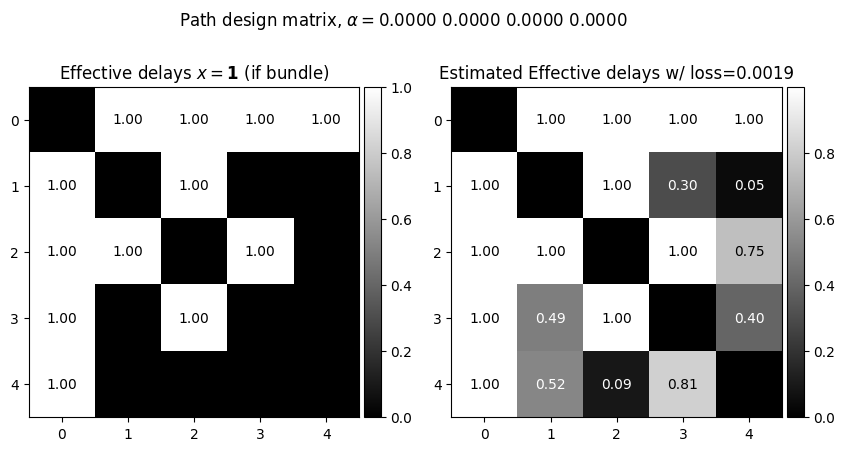

In [8]:
x_ground_mat = utils.add_diagonal_entries(x_ground.reshape(adj.shape[0], adj.shape[1]-1))
x_pred_mat = utils.add_diagonal_entries(x_opt.reshape(adj.shape[0], adj.shape[1]-1))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle(rf"Path design matrix, $\alpha=$"+" ".join([f"{a:1.4f}" for a in list(alpha)]))
axes[0].imshow(x_ground_mat, cmap='gray')
axes[0].set_title("Effective delays $x=\mathbf{1}$ (if bundle)")
utils.add_cbar(fig, axes[0])
utils.annotate_heatmap(fig, axes[0], x_ground_mat, adapt_color=0.6)

axes[1].imshow(x_pred_mat, cmap='gray')#, vmax=y_pred_mat.max())
axes[1].set_title(f"Estimated Effective delays w/ loss={np.round(loss,4)}")
utils.add_cbar(fig, axes[1])
# NOTE: we need to rechek this, it seems that the colors are flipped? (transposed?)
utils.annotate_heatmap(fig, axes[1], x_pred_mat.T, adapt_color=0.6)

### Backward: Pseudo-inverse solution

In [9]:
max_path_depth = 4
multi_hops_design = regmod.get_path_matrices(adj, max_path_depth)

  0%|          | 0/20 [00:00<?, ?it/s]

In [10]:
x_ground = utils.remove_diagonal_entries(adj).flatten()

a = 0
# Computes the alpha vector as alpha_n = a^n
alpha = solver.torch.tensor([a**(i+1) for i in range(max_path_depth)])

design_model = solver.combine_paths_matrices_torch(solver.torch.tensor(multi_hops_design), alpha=alpha)
y_pred = solver.forward(design_model, solver.torch.tensor(x_ground)).numpy()

In [17]:
x_opt = solver.pseudo_inverse(y_pred, a_design=design_model.numpy())
y_est = design_model.numpy() @ x_opt
loss = np.linalg.norm(y_est - y_pred)

(<Figure size 1000x500 with 4 Axes>,
 <Axes: title={'center': 'Estimated Effective delays w/ loss=0.0'}>)

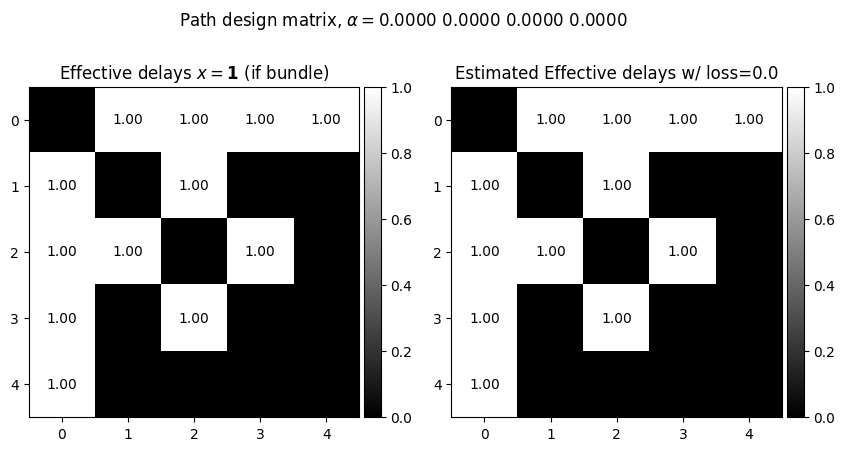

In [18]:
x_ground_mat = utils.add_diagonal_entries(x_ground.reshape(adj.shape[0], adj.shape[1]-1))
x_pred_mat = utils.add_diagonal_entries(x_opt.reshape(adj.shape[0], adj.shape[1]-1))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle(rf"Path design matrix, $\alpha=$"+" ".join([f"{a:1.4f}" for a in list(alpha)]))
axes[0].imshow(x_ground_mat, cmap='gray')
axes[0].set_title("Effective delays $x=\mathbf{1}$ (if bundle)")
utils.add_cbar(fig, axes[0])
utils.annotate_heatmap(fig, axes[0], x_ground_mat, adapt_color=0.6)

axes[1].imshow(x_pred_mat, cmap='gray')#, vmax=y_pred_mat.max())
axes[1].set_title(f"Estimated Effective delays w/ loss={np.round(loss,4)}")
utils.add_cbar(fig, axes[1])
utils.annotate_heatmap(fig, axes[1], np.round(x_pred_mat,4), adapt_color=0.6)

## F-tract Example

Contents:
- Sanity check 
    - generating measured delay by considering only 1s delay for all bundles
    - verifying that the solver regresses back the only 1 delays

- Regressing conductance delays

In [ ]:
import importlib
importlib.reload(solver)

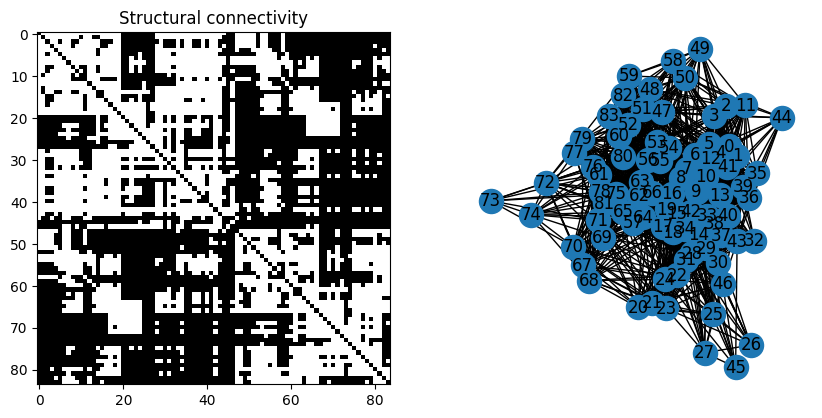

In [53]:
path_to_data = "../resources"

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

filename = "adjacency_atlas.pkl"

adj = utils.load(op.join(path_to_data, filename))
# TODO + NOTE: temporary truncation to remove (by michael)
adj = adj[:84, :84] 
adj -= np.diag(np.diag(adj))

axes[0].imshow(adj, cmap='gray')
axes[0].set_title('Structural connectivity')
toy_graph = nx.Graph(adj)
nx.draw(toy_graph, ax=axes[1], with_labels=True)

  0%|          | 0/6972 [00:00<?, ?it/s]

Early stopping !


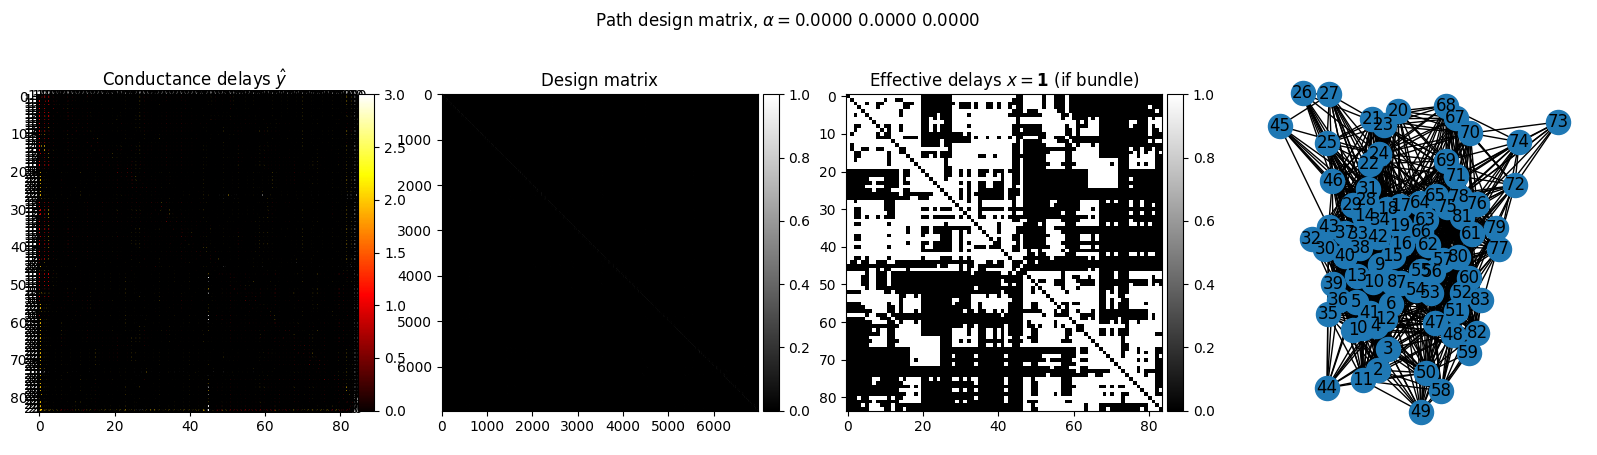

In [56]:
max_path_depth = 3

multi_hops_design = regmod.get_path_matrices(adj, max_path_depth)

a = 0
# Computes the alpha vector as alpha_n = a^n
alpha = [a**(i+1) for i in range(max_path_depth)]
#alpha = a

design_shortest = regmod.combine_paths_matrices(multi_hops_design, alpha=alpha)
design_model = design_shortest

y_pred_mat = regmod.predict_conduction_delays(design_model, adj, invert_weights=False)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(rf"Path design matrix, $\alpha=$"+" ".join([f"{a:1.4f}" for a in list(alpha)]))
axes[0].imshow(y_pred_mat, cmap='hot')
axes[0].set_title("Conductance delays $\hat{y}$")
utils.add_cbar(fig, axes[0])
utils.annotate_heatmap(fig, axes[0], y_pred_mat, adapt_color=0.6)

axes[1].imshow(design_model, cmap='gray')#, vmax=y_pred_mat.max())
axes[1].set_title("Design matrix")
utils.add_cbar(fig, axes[1])

axes[2].imshow(adj, cmap='gray')#, vmax=y_pred_mat.max())
axes[2].set_title("Effective delays $x=\mathbf{1}$ (if bundle)")
utils.add_cbar(fig, axes[2])

nx.draw(toy_graph, ax=axes[3], with_labels=True)

### Sanity check

In [57]:
x_ground = utils.remove_diagonal_entries(adj).flatten()

a = 0
# Computes the alpha vector as alpha_n = a^n
alpha = solver.torch.tensor([a**(i+1) for i in range(max_path_depth)])

design_model = solver.combine_paths_matrices_torch(solver.torch.tensor(multi_hops_design), alpha=alpha)
y_pred = solver.forward(design_model, solver.torch.tensor(x_ground)).numpy()

In [58]:
x_opt = solver.pseudo_inverse(y_pred, a_design=design_model.numpy())
y_est = design_model.numpy() @ x_opt
loss = np.linalg.norm(y_est - y_pred)

(<Figure size 1000x500 with 4 Axes>,
 <Axes: title={'center': 'Estimated Effective delays w/ loss=0.0'}>)

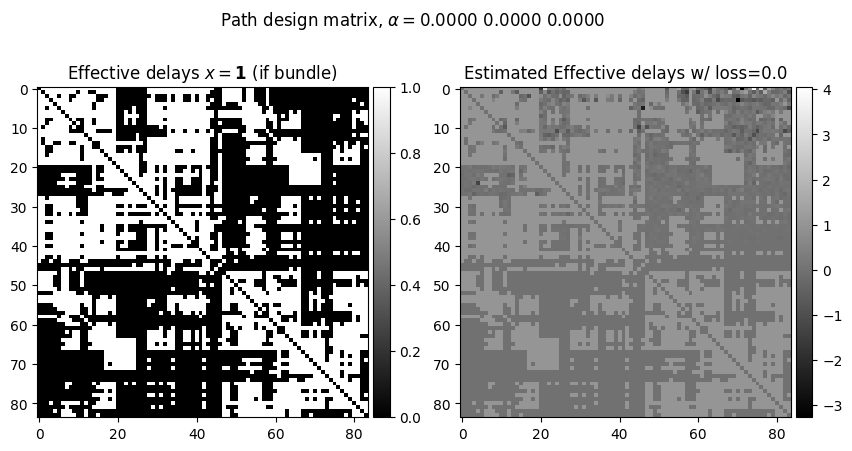

In [59]:
x_ground_mat = utils.add_diagonal_entries(x_ground.reshape(adj.shape[0], adj.shape[1]-1))
x_pred_mat = utils.add_diagonal_entries(x_opt.reshape(adj.shape[0], adj.shape[1]-1))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle(rf"Path design matrix, $\alpha=$"+" ".join([f"{a:1.4f}" for a in list(alpha)]))
axes[0].imshow(x_ground_mat, cmap='gray')
axes[0].set_title("Effective delays $x=\mathbf{1}$ (if bundle)")
utils.add_cbar(fig, axes[0])
# utils.annotate_heatmap(fig, axes[0], x_ground_mat, adapt_color=0.6)

axes[1].imshow(x_pred_mat, cmap='gray')#, vmax=y_pred_mat.max())
axes[1].set_title(f"Estimated Effective delays w/ loss={np.round(loss,4)}")
utils.add_cbar(fig, axes[1])
# utils.annotate_heatmap(fig, axes[1], np.round(x_pred_mat,4), adapt_color=0.6)

Text(0.5, 1.0, 'Difference (>10%) map between predicted and ground truth matrices')

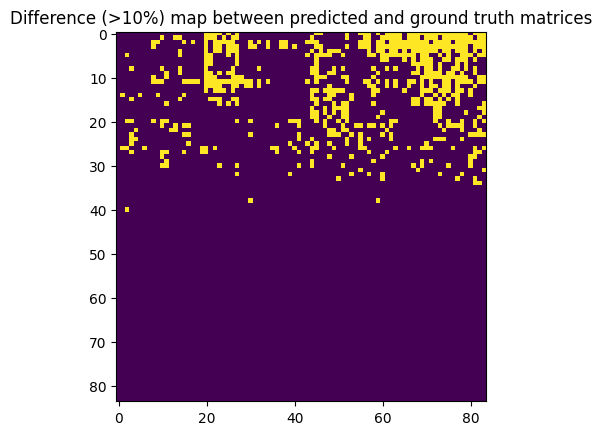

In [60]:
fig, ax = plt.subplots()
ax.imshow(np.abs(x_pred_mat - x_ground_mat) > 0.1)
ax.set_title('Difference (>10%) map between predicted and ground truth matrices')

### From conductance delay

In [61]:
y_ground = utils.load("../resources/conductance-delay_Lausanne2008_33.pkl")
y_ground = np.nan_to_num(y_ground['median'])
y_ground = utils.remove_diagonal_entries(y_ground).flatten()

In [62]:
a = 0
# Computes the alpha vector as alpha_n = a^n
alpha = solver.torch.tensor([a**(i+1) for i in range(max_path_depth)])

design_model = solver.combine_paths_matrices_torch(solver.torch.tensor(multi_hops_design), alpha=alpha).numpy()

In [63]:
x_opt = solver.pseudo_inverse(y_ground, a_design=design_model)
y_est = design_model @ x_opt
loss = np.linalg.norm(y_est - y_pred)

(<Figure size 1000x500 with 2 Axes>,
 <Axes: title={'center': 'Estimated Effective delays w/ loss=1296.5354'}>)

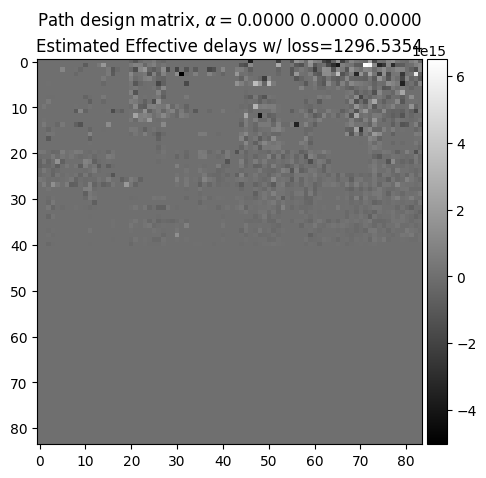

In [65]:
x_pred_mat = utils.add_diagonal_entries(x_opt.reshape(adj.shape[0], adj.shape[1]-1))

fig, axes = plt.subplots(figsize=(10, 5))
fig.suptitle(rf"Path design matrix, $\alpha=$"+" ".join([f"{a:1.4f}" for a in list(alpha)]))

axes.imshow(x_pred_mat, cmap='gray')#, vmax=y_pred_mat.max())
axes.set_title(f"Estimated Effective delays w/ loss={np.round(loss,4)}")
utils.add_cbar(fig, axes)
# utils.annotate_heatmap(fig, axes, np.round(x_pred_mat,4), adapt_color=0.6)